In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import os

In [3]:
data = pd.read_csv('/kaggle/input/apple-daily-dataset/AAPL_day_new_data.csv')

# AAPL

In [5]:
def preprocessing(data, flag=True):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if flag:
        scaler = MinMaxScaler()
        data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data

In [6]:
apple_stock = preprocessing(data)
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower' ]
BATCH_SIZE = 64
SEQUENCE_LENGTH = 10

<ipython-input-5-86a397dbe36d>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-5-86a397dbe36d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [7]:
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  
        label = targets[i + sequence_length] 
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    sequences = np.transpose(sequences, (0, 2, 1))  
    return sequences, labels

In [8]:
def prepare_dataloaders(data, feature_columns, target_column, sequence_length, batch_size, test_size=0.1):
    X = data[feature_columns].values
    y = data[target_column].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=test_size, shuffle=False)
    
    x_train, y_train = create_sequences(X_train, Y_train, sequence_length)
    x_val, y_val = create_sequences(X_val, Y_val, sequence_length)
    x_test, y_test = create_sequences(X_test, Y_test, sequence_length)
    
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader, y_test

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, drop_prob, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.dropout = nn.Dropout(drop_prob)
        self.batchnorm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.dropout(out)
        out = self.batchnorm(out)
        out = F.relu(out)
        return out


class FractalBlock(nn.Module):
    def __init__(self, n_columns, input_channels, output_channels, kernel_size, local_drop_prob, dropout_prob, global_drop_prob, training=True):
        super().__init__()
        self.n_columns = n_columns
        self.columns = nn.ModuleList([nn.ModuleList() for _ in range(n_columns)])
        self.max_depth = 2 ** (n_columns - 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob
        self.count = np.zeros([self.max_depth], dtype=int)
        
        dist = self.max_depth
        for col in self.columns:
            for i in range(self.max_depth):
                if (i + 1) % dist == 0:
                    first_block = (i + 1 == dist)
                    if first_block:
                        cur_input = input_channels
                    else:
                        cur_input = output_channels

                    module = ConvBlock(cur_input, output_channels, kernel_size, dropout_prob)
                    self.count[i] += 1
                else:
                    module = None
                col.append(module)
            dist //= 2

    def drop_mask(self, B, global_cols, n_cols):
        GB = global_cols.shape[0]
        gdrop_cols = global_cols - (self.n_columns - n_cols)
        gdrop_indices = np.where(gdrop_cols >= 0)[0]

        gdrop_mask = np.zeros([n_cols, GB], dtype=np.float32)
        gdrop_mask[gdrop_cols[gdrop_indices], gdrop_indices] = 1.
        LB = B - GB
        ldrop_mask = np.random.binomial(1, 1. - self.local_drop_prob, [n_cols, LB]).astype(np.float32)
        alive_count = ldrop_mask.sum(axis=0)

        dead_indices = np.where(alive_count == 0.)[0]
        ldrop_mask[np.random.randint(0, n_cols, size=dead_indices.shape), dead_indices] = 1.

        drop_mask = np.concatenate((gdrop_mask, ldrop_mask), axis=1)
        return torch.from_numpy(drop_mask)

    def join(self, outs, global_cols):
        n_cols = len(outs)
        out = torch.stack(outs) 

        if self.training:
            mask = self.drop_mask(out.size(1), global_cols, n_cols).to(out.device)  # [n_cols, B]
            mask = mask.view(*mask.size(), 1, 1) 
            n_alive = mask.sum(dim=0)  
            masked_out = out * mask  
            n_alive[n_alive == 0.] = 1.
            out = masked_out.sum(dim=0) / n_alive  
        else:
            out = out.mean(dim=0)
        return out

    def forward(self, x, global_cols):
        outs = [x] * self.n_columns
        for i in range(self.max_depth):
            st = self.n_columns - self.count[i]
            cur_outs = []

            for c in range(st, self.n_columns):
                cur_in = outs[c]
                cur_module = self.columns[c][i]
                if cur_module is not None:
                    cur_outs.append(cur_module(cur_in))

            joined = self.join(cur_outs, global_cols)

            for c in range(st, self.n_columns):
                outs[c] = joined

        outs[-1] = self.dropout(outs[-1])
        return outs[-1]



            
class HybridModel(nn.Module):
    def __init__(self, n_blocks, n_columns, input_channels, channels, lstm_hidden_size, lstm_num_layers, 
                 kernel_size, local_drop_prob, drop_prob, global_drop_prob):
        super().__init__()
        self.n_blocks = n_blocks
        self.n_columns = n_columns
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers

        self.fractal_layers = nn.ModuleList()
        total_layers = 0

        current_channels = input_channels
        for i in range(self.n_blocks):
            print(f"Block {i + 1}, Input channels: {current_channels}, Output channels: {channels[i]}")
            fractal_block = FractalBlock(n_columns, current_channels, channels[i], kernel_size, local_drop_prob,
                                         drop_prob, global_drop_prob)
            self.fractal_layers.append(fractal_block)
            self.fractal_layers.append(nn.BatchNorm1d(channels[i]))
            if i < self.n_blocks - 1:
                self.fractal_layers.append(nn.AvgPool1d(2))
            total_layers += fractal_block.max_depth
            current_channels = channels[i]
        
        print(f"Total fractal layers: {total_layers}")
        self.reshape = Reshape()
        
        self.lstm = nn.LSTM(
            input_size=current_channels, 
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            dropout=drop_prob if lstm_num_layers > 1 else 0
        )
        
        self.regression = nn.Sequential(
            nn.Linear(lstm_hidden_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1)
        )
        
        self.initialize_weights()

    def initialize_weights(self):
        for name, param in self.named_parameters():
            if param.dim() > 1:  
                if 'lstm' in name:
                    nn.init.orthogonal_(param)
                else:
                    nn.init.xavier_uniform_(param)
            else: 
                if 'bn.weight' in name:
                    nn.init.ones_(param)
                elif 'bn.bias' in name or 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        GB = int(x.size(0) * self.global_drop_prob)
        global_cols = None
        out = x

        for layer in self.fractal_layers:
            if isinstance(layer, FractalBlock):
                global_cols = np.random.randint(0, self.n_columns, size=[GB])
                out = layer(out, global_cols)
            else:
                out = layer(out)
        
        out = self.reshape(out)  
    
        lstm_out, (h_n, c_n) = self.lstm(out)
        
        last_hidden = h_n[-1]  
    
        x = self.regression(last_hidden)
        return x


class Reshape(nn.Module):
    def forward(self, x):
        return x.permute(0, 2, 1)

In [10]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            all_targets.append(targets.cpu().detach().numpy())
            all_outputs.append(outputs.cpu().detach().numpy())
            
    avg_loss = total_loss / len(dataloader.dataset)
    targets = np.concatenate(all_targets)
    outputs = np.concatenate(all_outputs)
    
    mse = np.mean((outputs - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(outputs - targets))
    
    return avg_loss, rmse, mae

In [11]:
def plot_metrics(predictions, targets, name):
    
    predictions_natural = predictions.flatten()
    targets_natural = targets.flatten() 

    plt.figure(figsize=(10, 6))
    plt.plot(targets_natural, label="Real Values", color='blue')
    plt.plot(predictions_natural, label="Predicted Values", color='red', linestyle='dashed')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Real vs Predicted Values')
    plt.legend()
    plt.savefig(name, dpi=99, bbox_inches='tight')
    plt.show()

In [12]:
def evaluate_on_test(model, test_dataloader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            loss = criterion(outputs, targets)  
            test_loss += loss.item() * inputs.size(0) 
            
            pred_np = outputs.cpu().numpy()
            target_np = targets.cpu().numpy()
            
            if np.ndim(pred_np) == 0:
                pred_np = np.array([pred_np])
            if np.ndim(target_np) == 0:
                target_np = np.array([target_np])
            
            all_predictions.append(outputs.cpu().numpy())  
            all_targets.append(targets.cpu().numpy())
    
    test_loss /= len(test_dataloader.dataset)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    
    return all_predictions, all_targets

In [13]:
def train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, name_model=""):
    model.to(device)
    best_val_loss = float('inf')
    
    train_rmse_list, train_mae_list = [], []
    val_rmse_list, val_mae_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        model.train()
        all_train_targets = []
        all_train_outputs = []
        batch_inputs, batch_targets = [], []

        for inputs, targets in train_dataloader:
            batch_inputs.append(inputs.to(device))
            batch_targets.append(targets.float().to(device))
        
        inputs = torch.cat(batch_inputs)
        targets = torch.cat(batch_targets)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        outputs = outputs.view_as(targets)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss = loss.item() * inputs.size(0)
        all_train_targets.append(targets.cpu().detach().numpy())
        all_train_outputs.append(outputs.cpu().detach().numpy())

        train_targets = np.concatenate(all_train_targets)
        train_outputs = np.concatenate(all_train_outputs)

        train_mse = np.mean((train_outputs - train_targets) ** 2)
        train_rmse = np.sqrt(train_mse)
        train_mae = np.mean(np.abs(train_outputs - train_targets))

        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
        train_loss_list.append(train_loss / len(train_dataloader.dataset))

        val_loss, val_rmse, val_mae = evaluate_model(model, val_dataloader, criterion, device)
        val_rmse_list.append(val_rmse)
        val_mae_list.append(val_mae)
        val_loss_list.append(val_loss)

        if val_loss < best_val_loss and name_model != '':
            best_val_loss = val_loss
            torch.save(model.state_dict(), name_model)

        if ((epoch + 1) % 100) == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
            print(f'Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

    if name_model != '':
        torch.save(model.state_dict(), name_model)

    return train_loss_list, val_loss_list

In [14]:
def evaluate_and_plot(test_dataloader, model, criterion, device, png, train_loss_list, val_loss_list, num_epochs):
    model.to(device)

    test_loss, test_rmse, test_mae = evaluate_model(model, test_dataloader, criterion, device)
    predictions, targets = evaluate_on_test(model, test_dataloader, criterion, device)

    print('\nFinal Results:')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

    plot_metrics(predictions, targets, png)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [15]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 

## LR

In [16]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0415, Train MAE: 0.0303
Val RMSE: 0.0536, Val MAE: 0.0442
Epoch 200/200:
Train RMSE: 0.0312, Train MAE: 0.0222
Val RMSE: 0.0849, Val MAE: 0.0764


In [17]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.1069, Train MAE: 0.0759
Val RMSE: 0.2764, Val MAE: 0.2728
Epoch 200/200:
Train RMSE: 0.0732, Train MAE: 0.0539
Val RMSE: 0.0836, Val MAE: 0.0676


In [18]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0242, Train MAE: 0.0166
Val RMSE: 0.1007, Val MAE: 0.0971
Epoch 200/200:
Train RMSE: 0.0186, Train MAE: 0.0128
Val RMSE: 0.1297, Val MAE: 0.1271


In [19]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.2150, Train MAE: 0.1463
Val RMSE: 0.5634, Val MAE: 0.5594
Epoch 200/200:
Train RMSE: 0.1858, Train MAE: 0.1158
Val RMSE: 0.5139, Val MAE: 0.5094


## Dropout

In [20]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.2
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0480, Train MAE: 0.0353
Val RMSE: 0.1019, Val MAE: 0.0960
Epoch 200/200:
Train RMSE: 0.0353, Train MAE: 0.0254
Val RMSE: 0.1527, Val MAE: 0.1480


In [21]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.3
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0535, Train MAE: 0.0397
Val RMSE: 0.1716, Val MAE: 0.1685
Epoch 200/200:
Train RMSE: 0.0403, Train MAE: 0.0297
Val RMSE: 0.2110, Val MAE: 0.2079


## Hidden size

In [22]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 1024
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0383, Train MAE: 0.0274
Val RMSE: 0.0641, Val MAE: 0.0540
Epoch 200/200:
Train RMSE: 0.0277, Train MAE: 0.0194
Val RMSE: 0.0825, Val MAE: 0.0741


In [23]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0429, Train MAE: 0.0312
Val RMSE: 0.0503, Val MAE: 0.0395
Epoch 200/200:
Train RMSE: 0.0308, Train MAE: 0.0224
Val RMSE: 0.0901, Val MAE: 0.0837


In [24]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0414, Train MAE: 0.0303
Val RMSE: 0.0420, Val MAE: 0.0329
Epoch 200/200:
Train RMSE: 0.0305, Train MAE: 0.0219
Val RMSE: 0.0728, Val MAE: 0.0647


## Number layers

In [25]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0288, Train MAE: 0.0204
Val RMSE: 0.0583, Val MAE: 0.0510
Epoch 200/200:
Train RMSE: 0.0229, Train MAE: 0.0160
Val RMSE: 0.0622, Val MAE: 0.0549


In [26]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 3
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.0259, Train MAE: 0.0181
Val RMSE: 0.0612, Val MAE: 0.0524
Epoch 200/200:
Train RMSE: 0.0217, Train MAE: 0.0146
Val RMSE: 0.0478, Val MAE: 0.0415


## Num epoches

In [27]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 400
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/400:
Train RMSE: 0.0415, Train MAE: 0.0303
Val RMSE: 0.0536, Val MAE: 0.0442
Epoch 200/400:
Train RMSE: 0.0312, Train MAE: 0.0222
Val RMSE: 0.0849, Val MAE: 0.0764
Epoch 300/400:
Train RMSE: 0.0264, Train MAE: 0.0188
Val RMSE: 0.0942, Val MAE: 0.0866
Epoch 400/400:
Train RMSE: 0.0237, Train MAE: 0.0167
Val RMSE: 0.1095, Val MAE: 0.1040


In [28]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 100
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/100:
Train RMSE: 0.0415, Train MAE: 0.0303
Val RMSE: 0.0536, Val MAE: 0.0442


## timestep = 5

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.1318, Train MAE: 0.0936
Val RMSE: 0.3755, Val MAE: 0.3724
Epoch 200/200:
Train RMSE: 0.0852, Train MAE: 0.0625
Val RMSE: 0.1690, Val MAE: 0.1612

Final Results:
Test RMSE: 0.0716
Test MAE: 0.0614


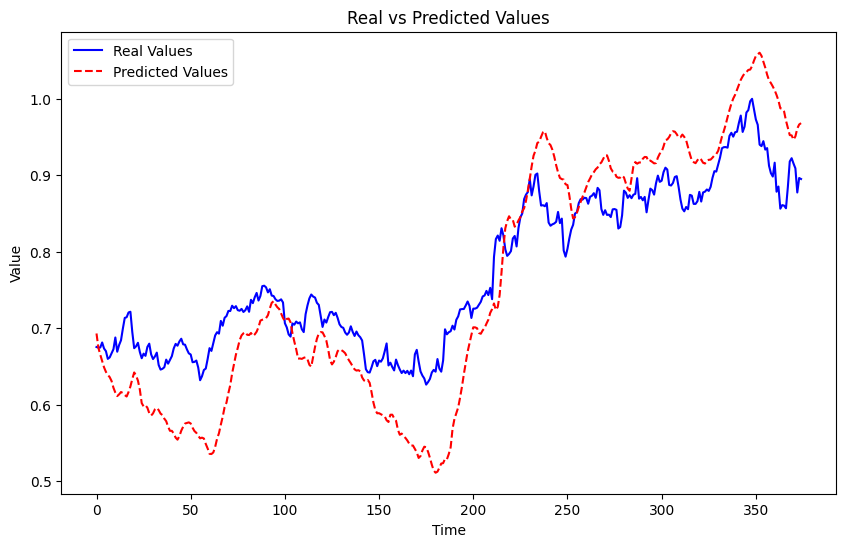

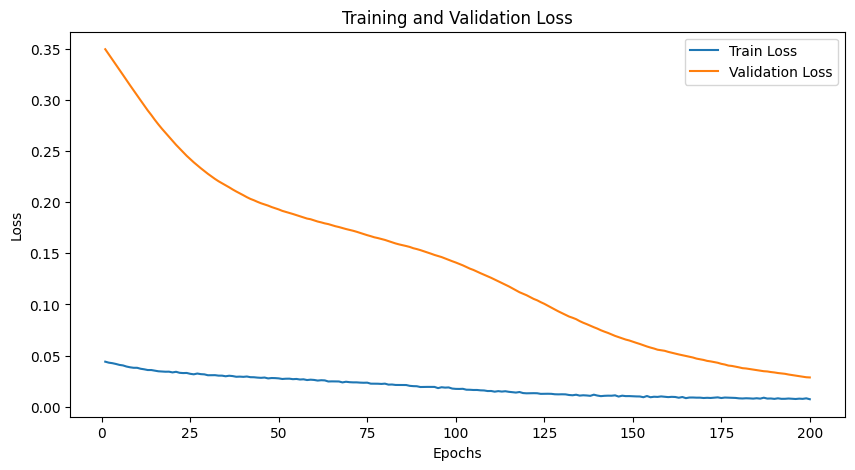

In [29]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_apple_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_5_fractal_lstm.png', train_losses, val_losses, num_epochs)

## timestep = 10

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.1181, Train MAE: 0.0844
Val RMSE: 0.2877, Val MAE: 0.2850
Epoch 200/200:
Train RMSE: 0.0798, Train MAE: 0.0586
Val RMSE: 0.0720, Val MAE: 0.0611

Final Results:
Test RMSE: 0.0331
Test MAE: 0.0256


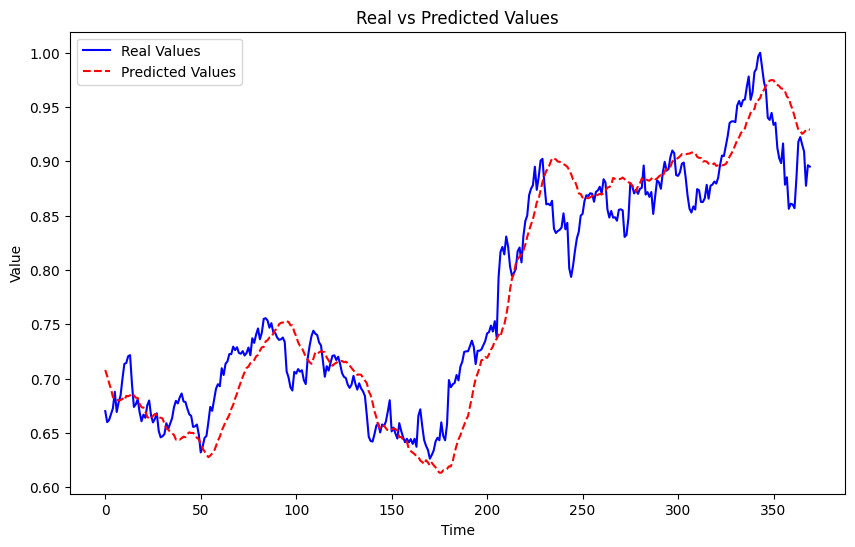

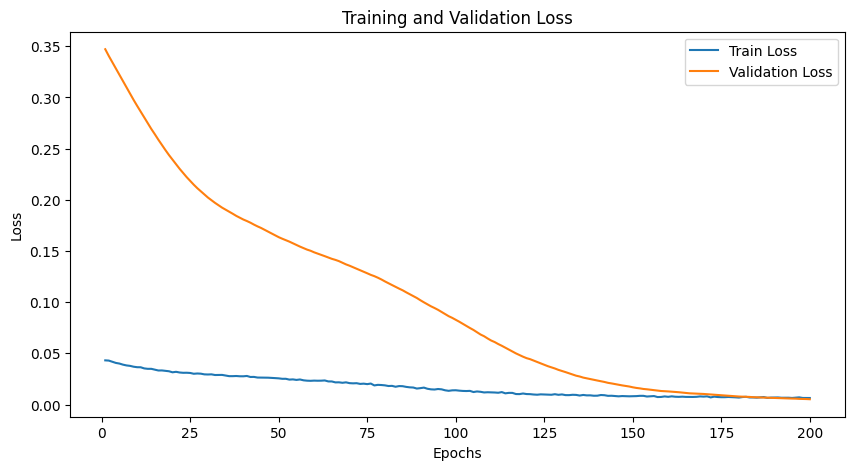

In [30]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_apple_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_10_fractal_lstm.png', train_losses, val_losses, num_epochs)

## timestep = 20

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.1106, Train MAE: 0.0795
Val RMSE: 0.2424, Val MAE: 0.2402
Epoch 200/200:
Train RMSE: 0.0744, Train MAE: 0.0549
Val RMSE: 0.0419, Val MAE: 0.0329

Final Results:
Test RMSE: 0.0327
Test MAE: 0.0264


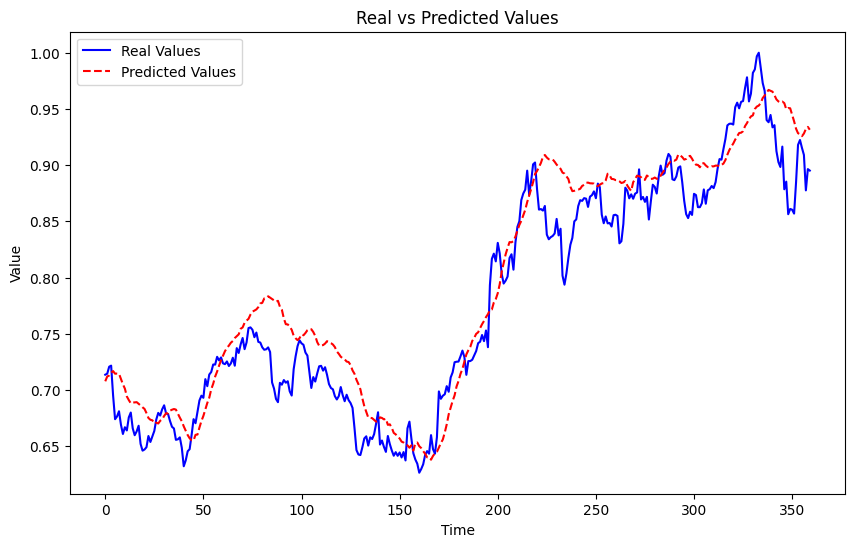

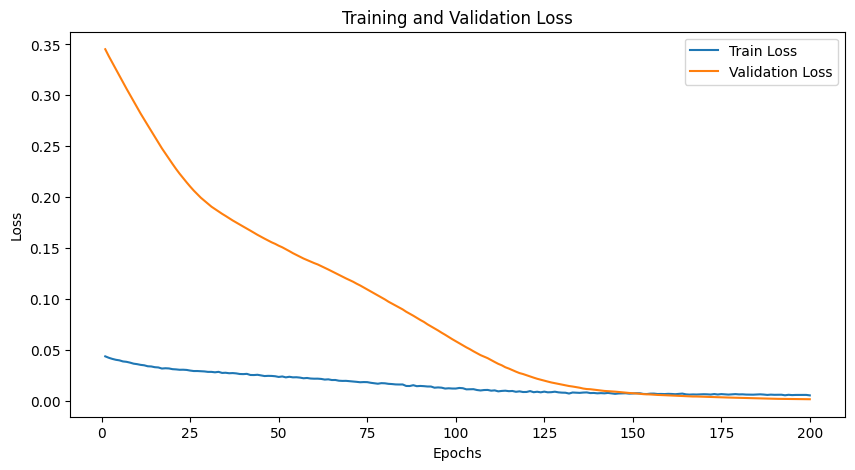

In [31]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_apple_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_20_fractal_lstm.png', train_losses, val_losses, num_epochs)

## Without indicator

In [32]:
cols = ['Open', 'Low', 'High', 'Volume', 'Close']
cols1 = ['Open', 'Low', 'High', 'Volume']

apple_stock_indicators = apple_stock[cols]

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.1343, Train MAE: 0.0950
Val RMSE: 0.4106, Val MAE: 0.4076
Epoch 200/200:
Train RMSE: 0.0883, Train MAE: 0.0639
Val RMSE: 0.1790, Val MAE: 0.1757

Final Results:
Test RMSE: 0.1055
Test MAE: 0.0965


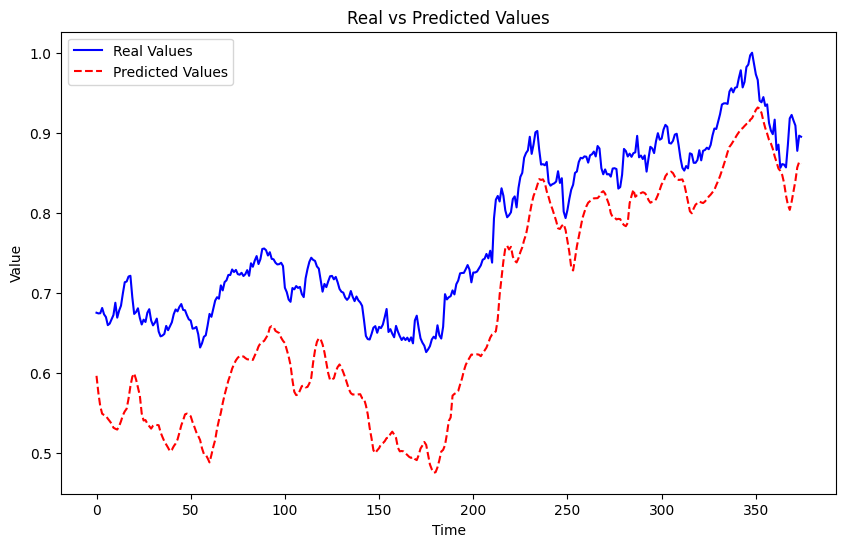

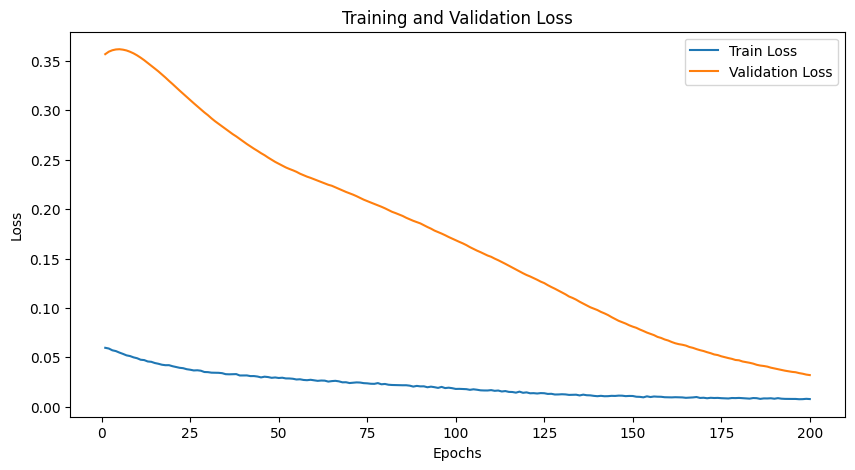

In [33]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock_indicators, cols1, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_apple_without_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device,  'apple_step_5_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.1127, Train MAE: 0.0806
Val RMSE: 0.3305, Val MAE: 0.3293
Epoch 200/200:
Train RMSE: 0.0798, Train MAE: 0.0592
Val RMSE: 0.1065, Val MAE: 0.0993

Final Results:
Test RMSE: 0.0447
Test MAE: 0.0371


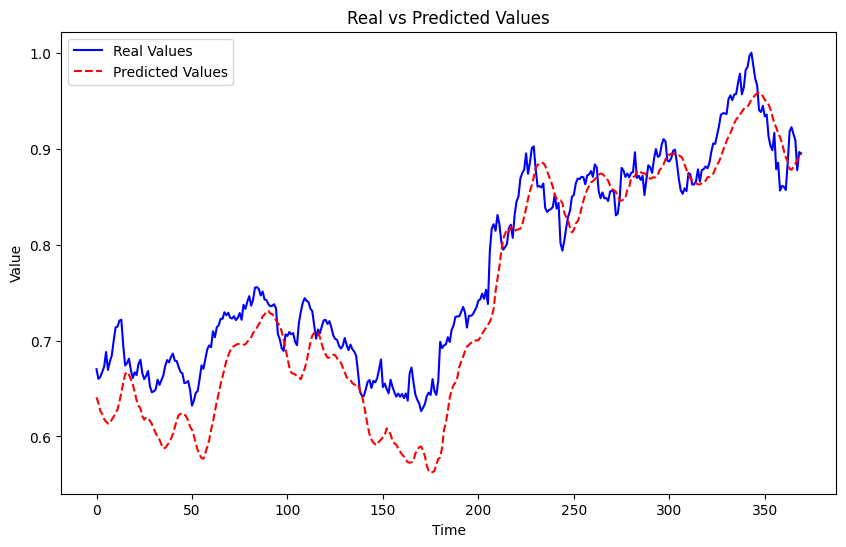

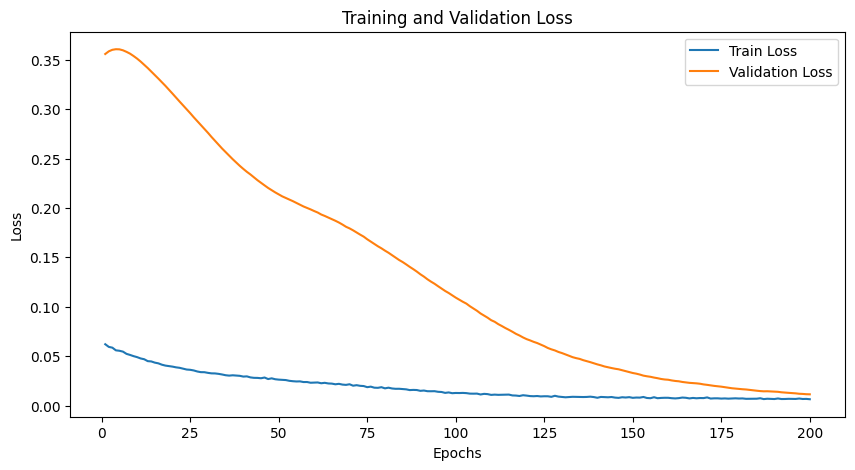

In [34]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock_indicators, cols1, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_apple_without_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_10_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 16
Epoch 100/200:
Train RMSE: 0.1106, Train MAE: 0.0804
Val RMSE: 0.2883, Val MAE: 0.2871
Epoch 200/200:
Train RMSE: 0.0758, Train MAE: 0.0557
Val RMSE: 0.0669, Val MAE: 0.0579

Final Results:
Test RMSE: 0.0270
Test MAE: 0.0215


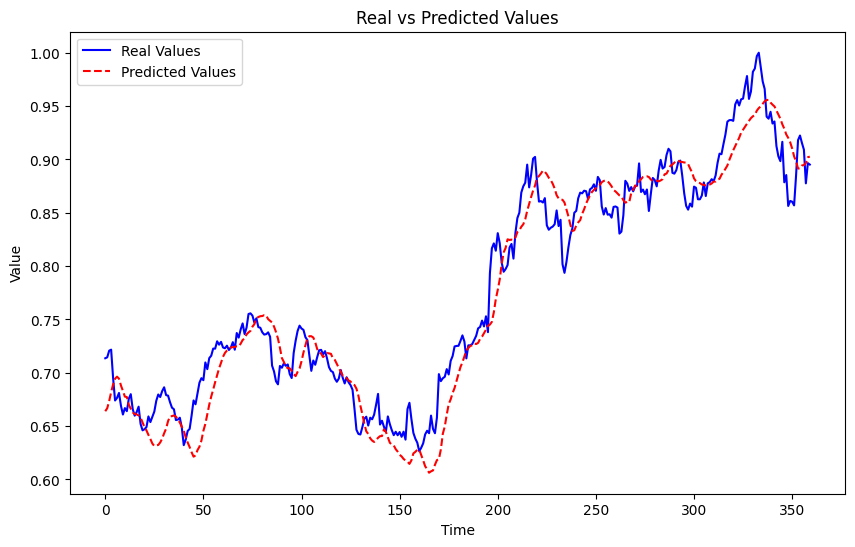

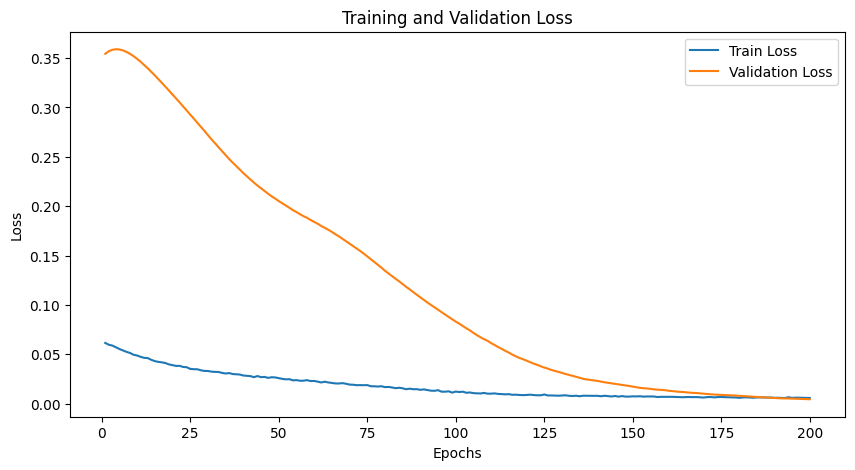

In [36]:
seed_everything(0)
n_blocks = 2
n_columns = 4
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock_indicators, cols1, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_apple_without_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_20_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

# META

In [35]:
data = pd.read_csv('/kaggle/input/meta-dataset/META_day.csv')
meta_stock = preprocessing(data)
meta_stock.tail()

<ipython-input-5-86a397dbe36d>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-5-86a397dbe36d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2025-04-28,0.749487,0.748276,0.739388,0.740697,0.018375,0.906076,0.871400,0.441323,0.209590,0.057638,0.775363,0.712104
2025-04-29,0.736048,0.745617,0.744377,0.747239,0.012497,0.900351,0.870095,0.457564,0.262783,0.092388,0.770651,0.714116
2025-04-30,0.725454,0.735272,0.723713,0.739667,0.043101,0.895094,0.868506,0.437595,0.300065,0.128458,0.761696,0.718664
2025-05-01,0.800285,0.796000,0.781663,0.771976,0.046372,0.890966,0.868410,0.518210,0.362421,0.171143,0.758003,0.721092
2025-05-02,0.788261,0.805667,0.792730,0.805371,0.012139,0.887875,0.869796,0.588880,0.444745,0.223551,0.772604,0.714337


## Learning rate

In [37]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0386, Train MAE: 0.0295
Val RMSE: 0.0376, Val MAE: 0.0340
Epoch 200/200:
Train RMSE: 0.0295, Train MAE: 0.0226
Val RMSE: 0.0549, Val MAE: 0.0523


In [38]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0705, Train MAE: 0.0536
Val RMSE: 0.0303, Val MAE: 0.0256
Epoch 200/200:
Train RMSE: 0.0602, Train MAE: 0.0460
Val RMSE: 0.0294, Val MAE: 0.0234


In [39]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.1870, Train MAE: 0.1547
Val RMSE: 0.2745, Val MAE: 0.2592
Epoch 200/200:
Train RMSE: 0.1536, Train MAE: 0.1228
Val RMSE: 0.2180, Val MAE: 0.1996


In [40]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0247, Train MAE: 0.0184
Val RMSE: 0.0578, Val MAE: 0.0557
Epoch 200/200:
Train RMSE: 0.0202, Train MAE: 0.0147
Val RMSE: 0.0754, Val MAE: 0.0729


## Hid size

In [41]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 1024
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0364, Train MAE: 0.0271
Val RMSE: 0.0373, Val MAE: 0.0339
Epoch 200/200:
Train RMSE: 0.0274, Train MAE: 0.0206
Val RMSE: 0.0472, Val MAE: 0.0449


In [42]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0406, Train MAE: 0.0308
Val RMSE: 0.0306, Val MAE: 0.0276
Epoch 200/200:
Train RMSE: 0.0308, Train MAE: 0.0237
Val RMSE: 0.0502, Val MAE: 0.0479


## Num layers

In [43]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0250, Train MAE: 0.0192
Val RMSE: 0.0435, Val MAE: 0.0393
Epoch 200/200:
Train RMSE: 0.0218, Train MAE: 0.0162
Val RMSE: 0.0417, Val MAE: 0.0377


In [44]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 3
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0222, Train MAE: 0.0166
Val RMSE: 0.0351, Val MAE: 0.0315
Epoch 200/200:
Train RMSE: 0.0192, Train MAE: 0.0143
Val RMSE: 0.0304, Val MAE: 0.0269


## Number epoches

In [45]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 300
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/300:
Train RMSE: 0.0386, Train MAE: 0.0295
Val RMSE: 0.0376, Val MAE: 0.0340
Epoch 200/300:
Train RMSE: 0.0295, Train MAE: 0.0226
Val RMSE: 0.0549, Val MAE: 0.0523
Epoch 300/300:
Train RMSE: 0.0253, Train MAE: 0.0190
Val RMSE: 0.0586, Val MAE: 0.0562


In [46]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 400
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/400:
Train RMSE: 0.0386, Train MAE: 0.0295
Val RMSE: 0.0376, Val MAE: 0.0340
Epoch 200/400:
Train RMSE: 0.0295, Train MAE: 0.0226
Val RMSE: 0.0549, Val MAE: 0.0523
Epoch 300/400:
Train RMSE: 0.0253, Train MAE: 0.0190
Val RMSE: 0.0586, Val MAE: 0.0562
Epoch 400/400:
Train RMSE: 0.0218, Train MAE: 0.0165
Val RMSE: 0.0707, Val MAE: 0.0678


In [47]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 100
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/100:
Train RMSE: 0.0386, Train MAE: 0.0295
Val RMSE: 0.0376, Val MAE: 0.0340


## Timestep = 5

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.1093, Train MAE: 0.0837
Val RMSE: 0.0994, Val MAE: 0.0860
Epoch 200/200:
Train RMSE: 0.0738, Train MAE: 0.0565
Val RMSE: 0.0215, Val MAE: 0.0168

Final Results:
Test RMSE: 0.0474
Test MAE: 0.0356


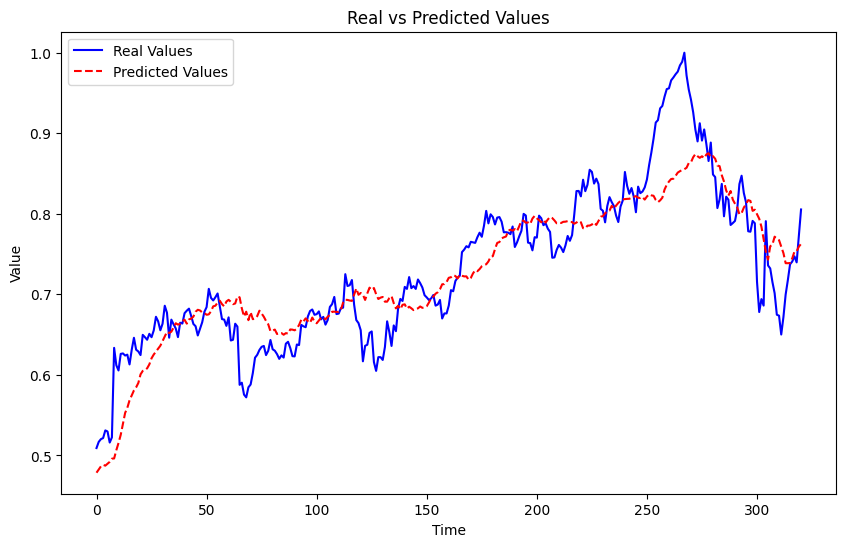

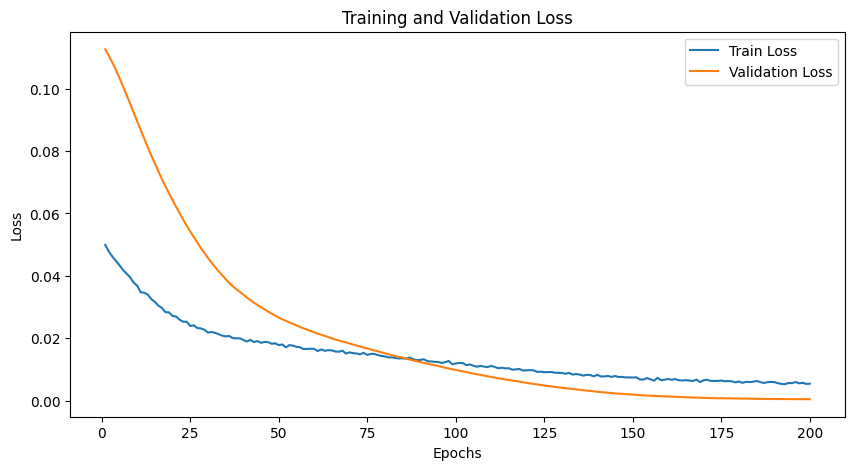

In [48]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_meta_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_5_fractal_lstm.png', train_losses, val_losses, num_epochs)

## Timestep = 10

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.1033, Train MAE: 0.0782
Val RMSE: 0.0801, Val MAE: 0.0696
Epoch 200/200:
Train RMSE: 0.0680, Train MAE: 0.0514
Val RMSE: 0.0275, Val MAE: 0.0239

Final Results:
Test RMSE: 0.0442
Test MAE: 0.0338


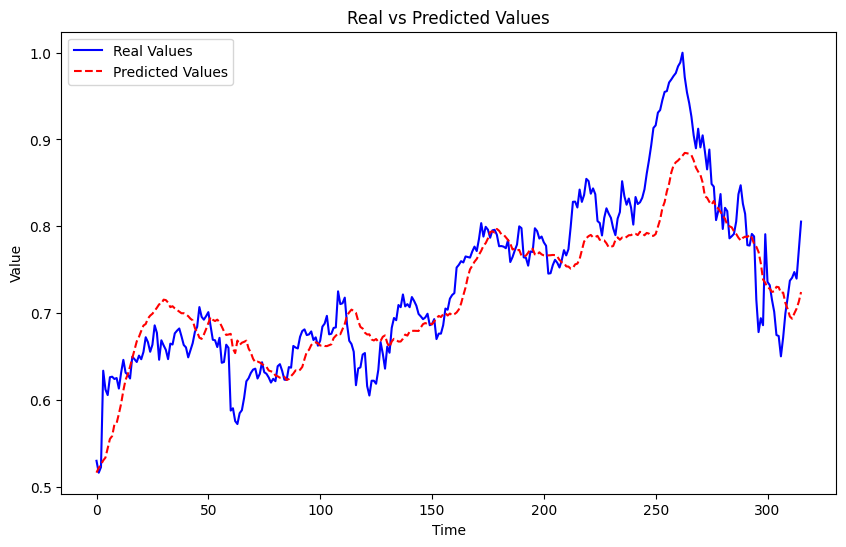

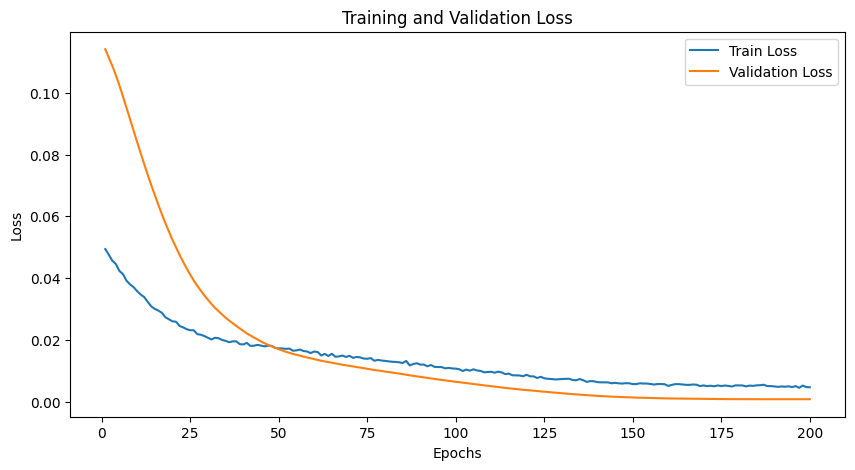

In [49]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_meta_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_10_fractal_lstm.png', train_losses, val_losses, num_epochs)

## Timestep = 20

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0998, Train MAE: 0.0757
Val RMSE: 0.0727, Val MAE: 0.0625
Epoch 200/200:
Train RMSE: 0.0661, Train MAE: 0.0503
Val RMSE: 0.0278, Val MAE: 0.0234

Final Results:
Test RMSE: 0.0513
Test MAE: 0.0395


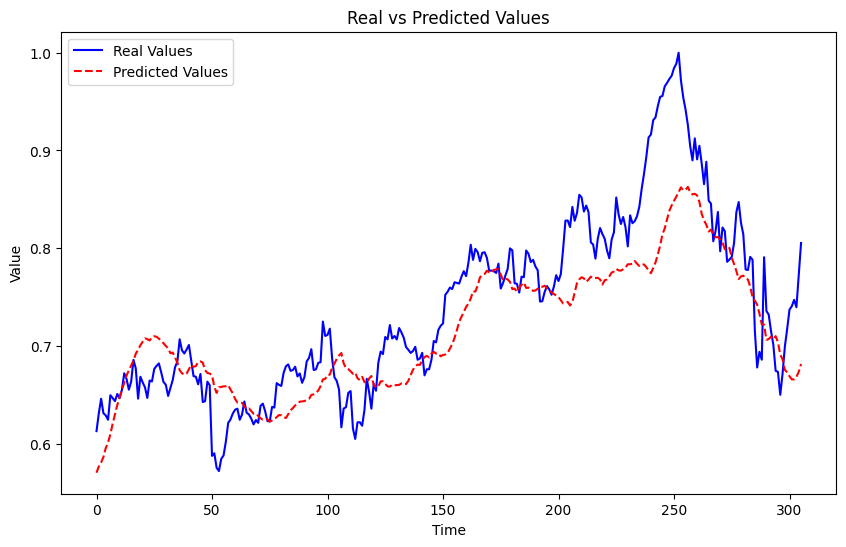

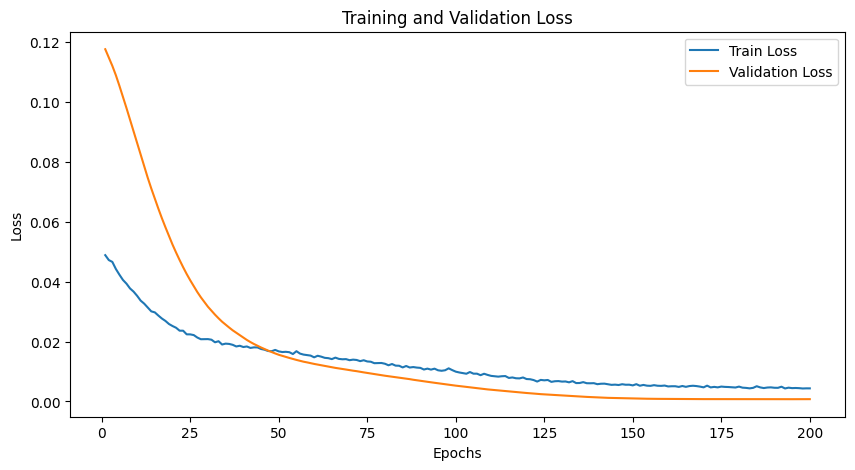

In [50]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_meta_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_20_fractal_lstm.png', train_losses, val_losses, num_epochs)

## without indicators

In [51]:
cols = ['Open', 'Low', 'High', 'Volume', 'Close']
cols1 = ['Open', 'Low', 'High', 'Volume']

meta_stock_indicators = meta_stock[cols]

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0927, Train MAE: 0.0713
Val RMSE: 0.0984, Val MAE: 0.0864
Epoch 200/200:
Train RMSE: 0.0690, Train MAE: 0.0512
Val RMSE: 0.0227, Val MAE: 0.0184

Final Results:
Test RMSE: 0.0719
Test MAE: 0.0629


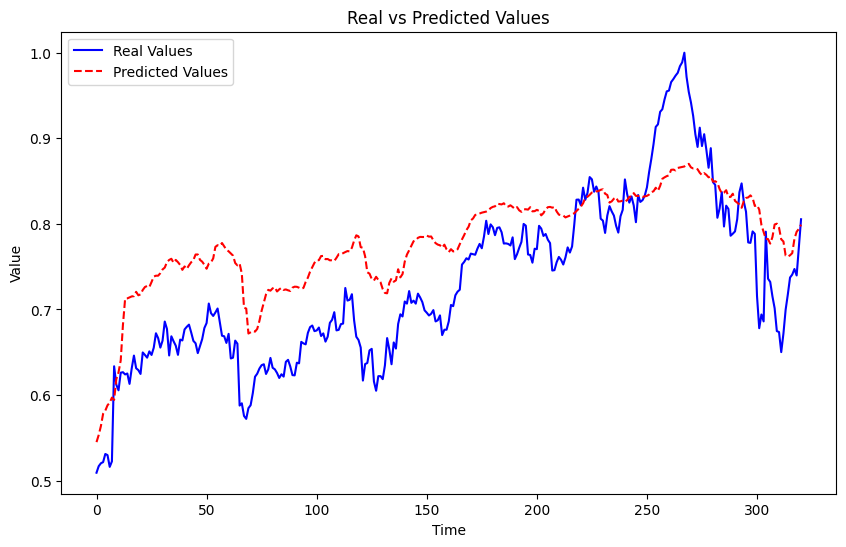

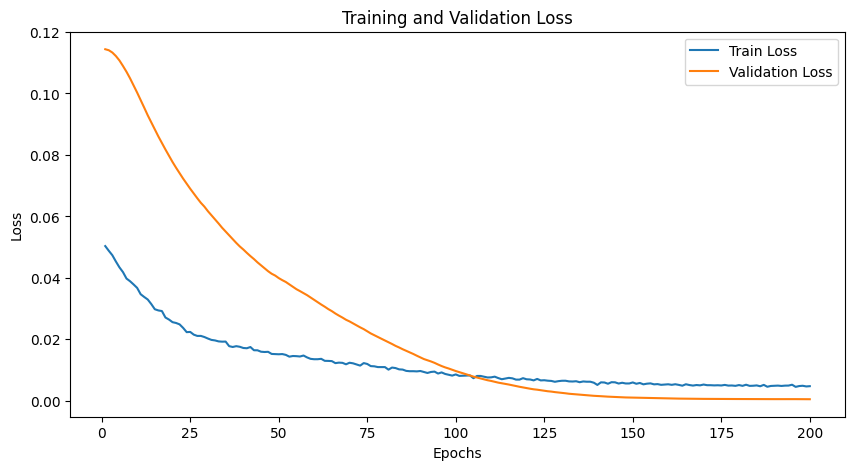

In [52]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock_indicators, cols1, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_meta_without_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device,  'meta_step_5_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0807, Train MAE: 0.0610
Val RMSE: 0.0565, Val MAE: 0.0502
Epoch 200/200:
Train RMSE: 0.0635, Train MAE: 0.0480
Val RMSE: 0.0170, Val MAE: 0.0132

Final Results:
Test RMSE: 0.0626
Test MAE: 0.0467


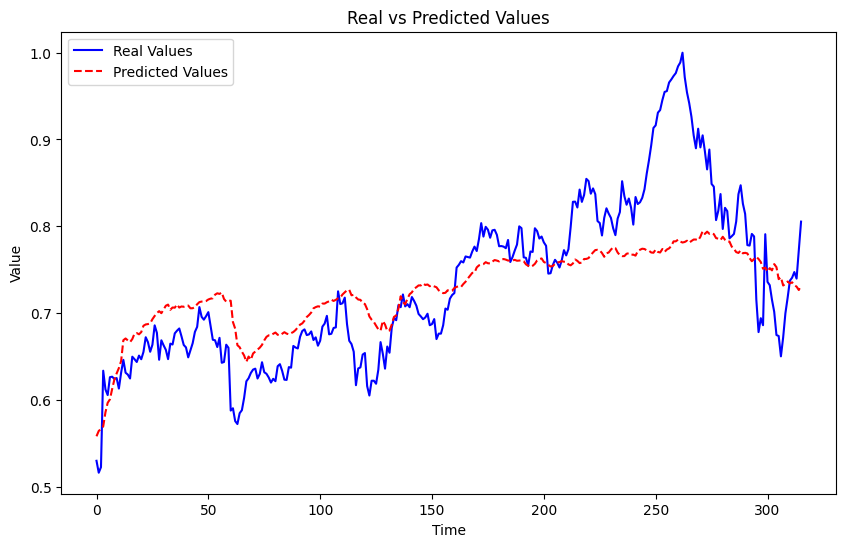

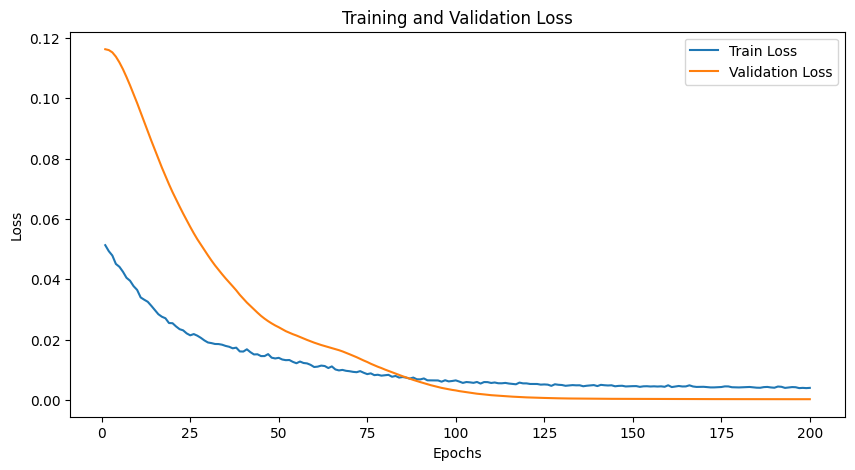

In [53]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock_indicators, cols1, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_meta_without_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_10_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0758, Train MAE: 0.0573
Val RMSE: 0.0469, Val MAE: 0.0421
Epoch 200/200:
Train RMSE: 0.0623, Train MAE: 0.0474
Val RMSE: 0.0232, Val MAE: 0.0189

Final Results:
Test RMSE: 0.0614
Test MAE: 0.0445


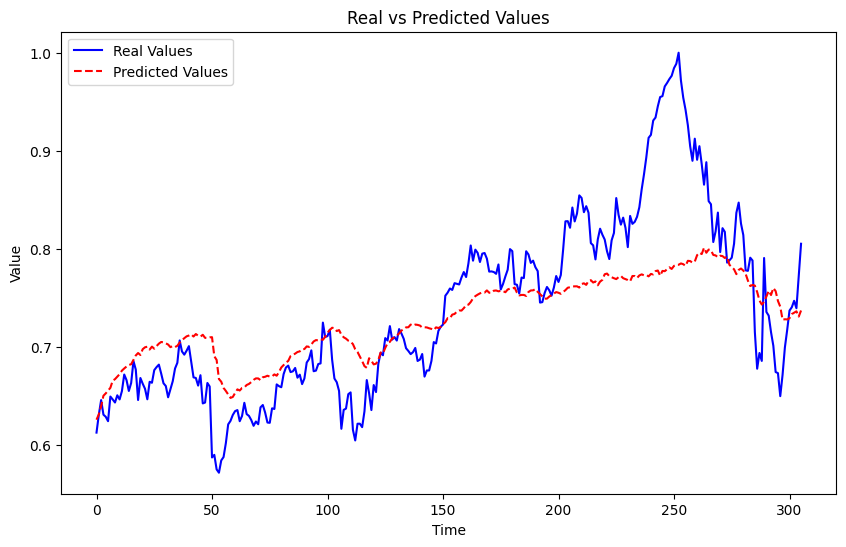

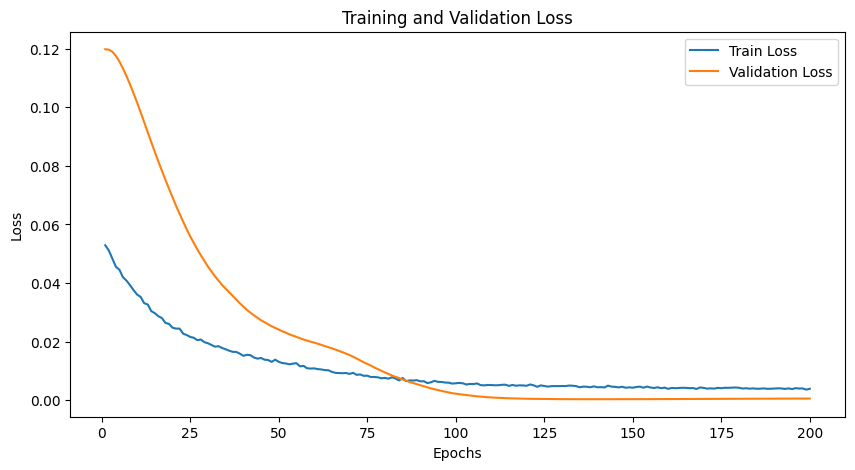

In [54]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock_indicators, cols1, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_meta_without_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_20_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

# TESLA

In [55]:
data = pd.read_csv('/kaggle/input/tesla-dataset/Tesla_day.csv')
tesla_stock = preprocessing(data)
tesla_stock.tail()

<ipython-input-5-86a397dbe36d>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-5-86a397dbe36d>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
Date,,,,,,,,,,,,
2025-04-28,0.606338,0.602652,0.594556,0.594868,0.164369,0.668509,0.714936,0.538552,0.452898,0.377682,0.586609,0.570638
2025-04-29,0.599009,0.599492,0.609999,0.607712,0.117427,0.665325,0.716542,0.559510,0.488656,0.403206,0.597159,0.565613
2025-04-30,0.587215,0.581295,0.590963,0.587099,0.139409,0.661734,0.717078,0.510602,0.506086,0.427586,0.601176,0.564011
2025-05-01,0.587447,0.594466,0.610743,0.583673,0.107290,0.657739,0.717427,0.502496,0.517583,0.449703,0.600390,0.564440
2025-05-02,0.597746,0.602488,0.610743,0.597646,0.123125,0.654385,0.718443,0.529324,0.533031,0.470906,0.606345,0.561966


## Learning Rate

In [56]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0407, Train MAE: 0.0271
Val RMSE: 0.0339, Val MAE: 0.0274
Epoch 200/200:
Train RMSE: 0.0328, Train MAE: 0.0207
Val RMSE: 0.0566, Val MAE: 0.0477


In [57]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0775, Train MAE: 0.0523
Val RMSE: 0.1717, Val MAE: 0.1630
Epoch 200/200:
Train RMSE: 0.0644, Train MAE: 0.0434
Val RMSE: 0.0671, Val MAE: 0.0538


In [58]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0263, Train MAE: 0.0154
Val RMSE: 0.0869, Val MAE: 0.0788
Epoch 200/200:
Train RMSE: 0.0237, Train MAE: 0.0129
Val RMSE: 0.1264, Val MAE: 0.1172


## Hidden Size

In [59]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0433, Train MAE: 0.0284
Val RMSE: 0.0347, Val MAE: 0.0282
Epoch 200/200:
Train RMSE: 0.0319, Train MAE: 0.0201
Val RMSE: 0.0476, Val MAE: 0.0393


In [60]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 128
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0427, Train MAE: 0.0289
Val RMSE: 0.0444, Val MAE: 0.0347
Epoch 200/200:
Train RMSE: 0.0359, Train MAE: 0.0226
Val RMSE: 0.0516, Val MAE: 0.0432


## Num Layers

In [61]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0300, Train MAE: 0.0168
Val RMSE: 0.0456, Val MAE: 0.0350
Epoch 200/200:
Train RMSE: 0.0263, Train MAE: 0.0144
Val RMSE: 0.0370, Val MAE: 0.0292


## Num Epoches

In [62]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 100
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/100:
Train RMSE: 0.0407, Train MAE: 0.0271
Val RMSE: 0.0339, Val MAE: 0.0274


In [63]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 512
lstm_num_layers = 1
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 250
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/250:
Train RMSE: 0.0407, Train MAE: 0.0271
Val RMSE: 0.0339, Val MAE: 0.0274
Epoch 200/250:
Train RMSE: 0.0328, Train MAE: 0.0207
Val RMSE: 0.0566, Val MAE: 0.0477


## TimeStep = 5

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0340, Train MAE: 0.0201
Val RMSE: 0.0566, Val MAE: 0.0476
Epoch 200/200:
Train RMSE: 0.0285, Train MAE: 0.0158
Val RMSE: 0.0535, Val MAE: 0.0474

Final Results:
Test RMSE: 0.0754
Test MAE: 0.0627


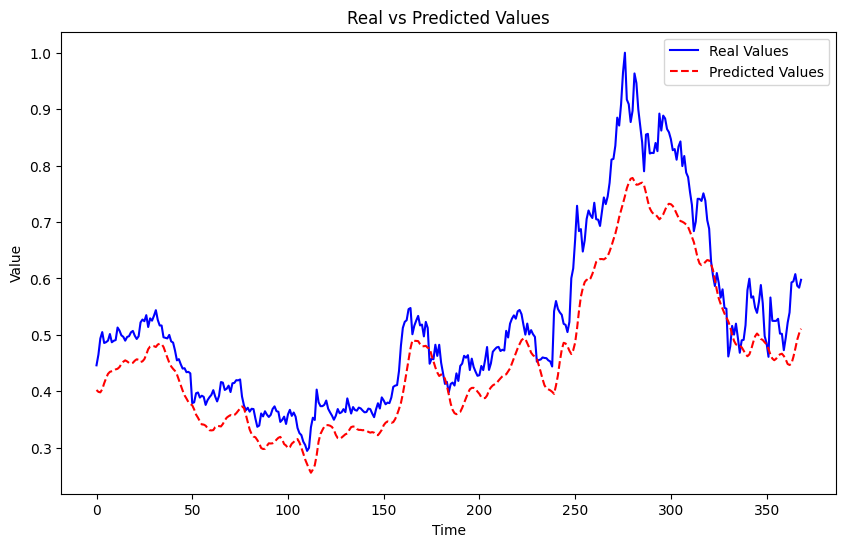

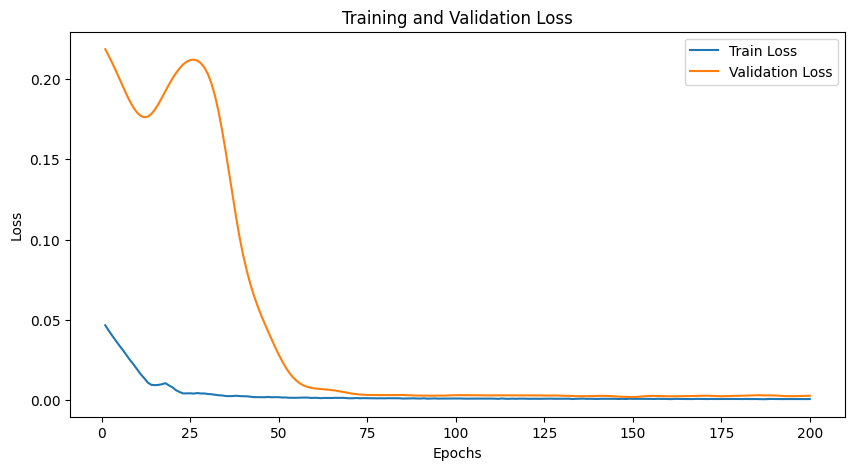

In [64]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_lstm_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_lstm_step_5_fractal.png', train_losses, val_losses, num_epochs)

## TimeStep = 10

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0331, Train MAE: 0.0185
Val RMSE: 0.0362, Val MAE: 0.0286
Epoch 200/200:
Train RMSE: 0.0255, Train MAE: 0.0146
Val RMSE: 0.0374, Val MAE: 0.0298

Final Results:
Test RMSE: 0.0553
Test MAE: 0.0397


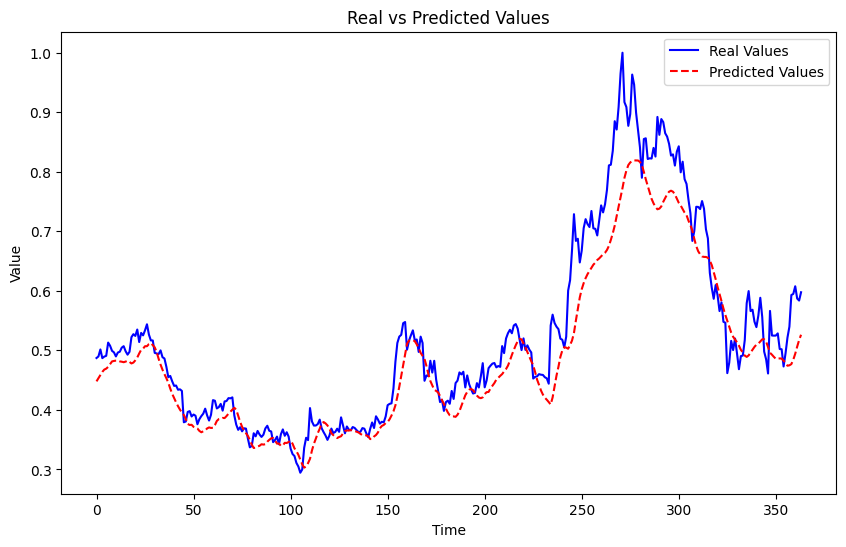

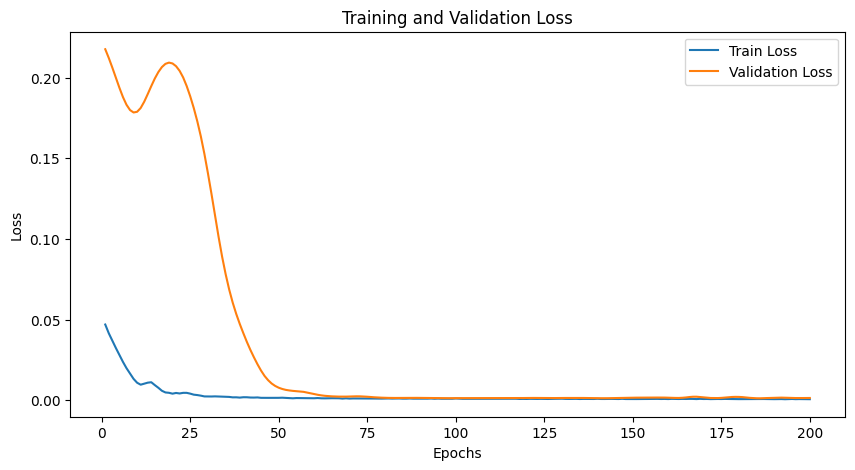

In [65]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_lstm_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_10_fractal_lstm.png', train_losses, val_losses, num_epochs)

## TimeStep = 20

Block 1, Input channels: 11, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0301, Train MAE: 0.0172
Val RMSE: 0.0351, Val MAE: 0.0279
Epoch 200/200:
Train RMSE: 0.0258, Train MAE: 0.0146
Val RMSE: 0.0364, Val MAE: 0.0285

Final Results:
Test RMSE: 0.0549
Test MAE: 0.0378


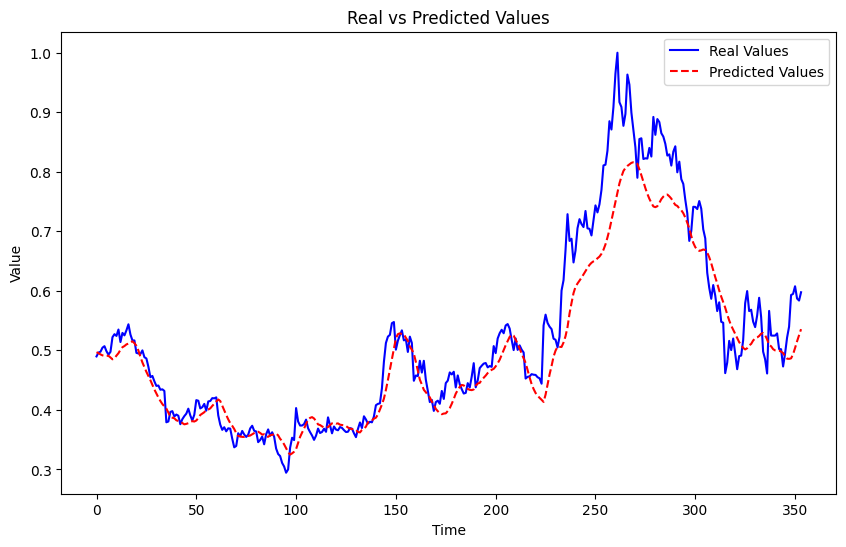

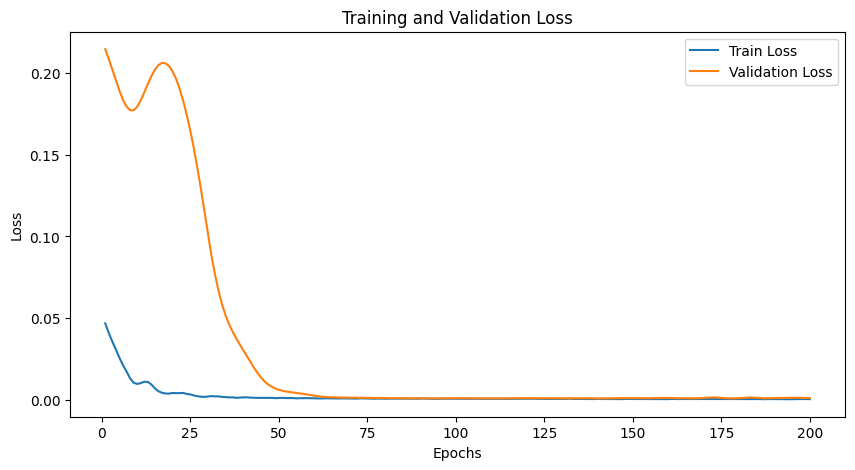

In [66]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 11
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_tesla_lstm_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_20_fractal_lstm.png', train_losses, val_losses, num_epochs)

## Without Indicators

In [67]:
cols = ['Open', 'Low', 'High', 'Volume', 'Close']
cols1 = ['Open', 'Low', 'High', 'Volume']

tesla_stock_indicators = tesla_stock[cols]

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0894, Train MAE: 0.0524
Val RMSE: 0.3349, Val MAE: 0.3322
Epoch 200/200:
Train RMSE: 0.0612, Train MAE: 0.0360
Val RMSE: 0.1921, Val MAE: 0.1793

Final Results:
Test RMSE: 0.1898
Test MAE: 0.1698


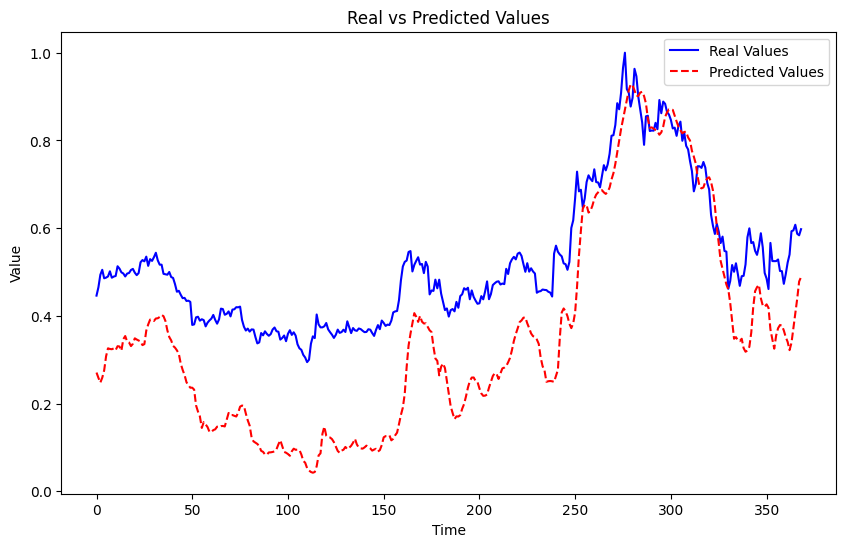

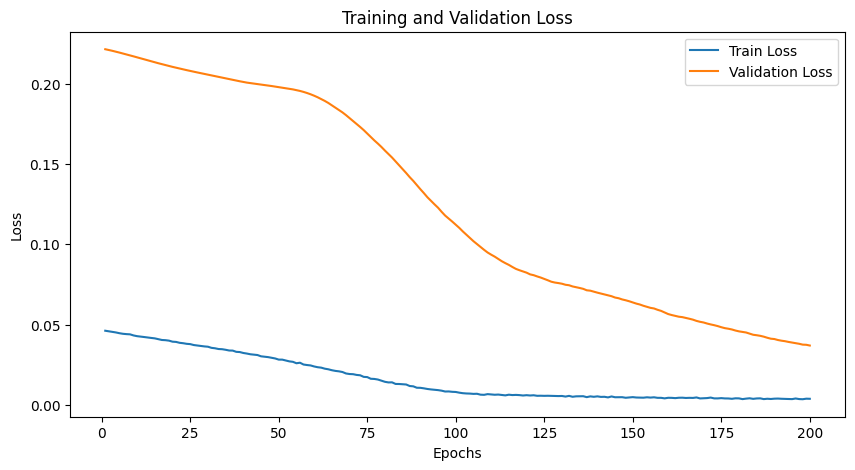

In [68]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock_indicators, cols1, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_tesla_without_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device,  'tesla_step_5_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0810, Train MAE: 0.0471
Val RMSE: 0.3261, Val MAE: 0.3222
Epoch 200/200:
Train RMSE: 0.0566, Train MAE: 0.0322
Val RMSE: 0.1680, Val MAE: 0.1531

Final Results:
Test RMSE: 0.1768
Test MAE: 0.1575


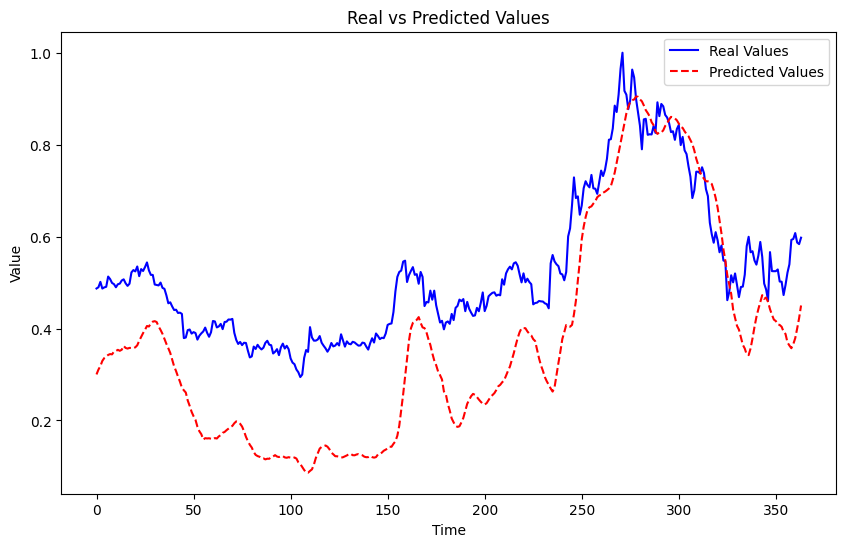

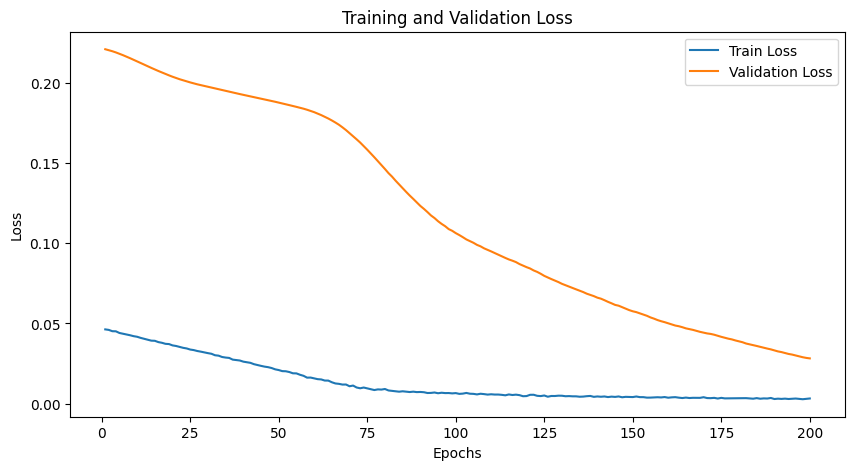

In [69]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200

model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock_indicators, cols1, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_tesla_without_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_10_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

Block 1, Input channels: 4, Output channels: 64
Block 2, Input channels: 64, Output channels: 128
Total fractal layers: 8
Epoch 100/200:
Train RMSE: 0.0774, Train MAE: 0.0446
Val RMSE: 0.3165, Val MAE: 0.3128
Epoch 200/200:
Train RMSE: 0.0483, Train MAE: 0.0276
Val RMSE: 0.1253, Val MAE: 0.1102

Final Results:
Test RMSE: 0.1460
Test MAE: 0.1284


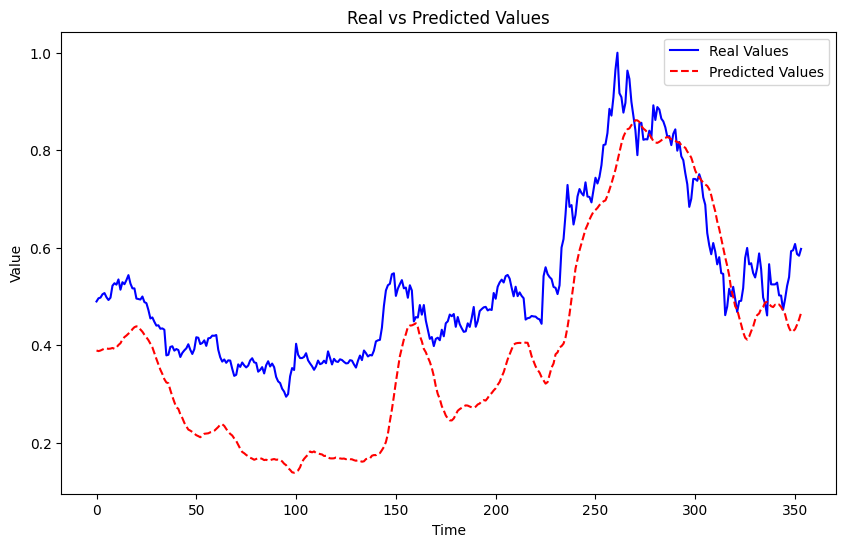

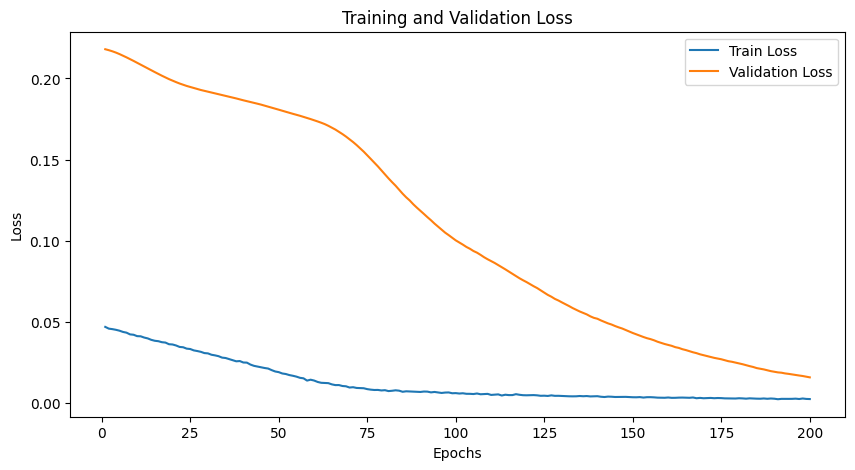

In [70]:
seed_everything(0)
n_blocks = 2
n_columns = 3
input_channels = 4
channels = [64, 128]  
lstm_hidden_size = 256
lstm_num_layers = 2
kernel_size = 3
local_drop_prob = 0.3
drop_prob = 0.1
global_drop_prob = 0.3
num_epochs = 200
    
model = HybridModel(
        n_blocks=n_blocks,
        n_columns=n_columns,
        input_channels=input_channels,
        channels=channels,
        lstm_hidden_size=lstm_hidden_size,
        lstm_num_layers=lstm_num_layers,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
    )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock_indicators, cols1, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_lstm_model_tesla_without_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_20_without_fractal_lstm.png', train_losses, val_losses, num_epochs)

## 